In [1]:
import numpy as np
import pandas as pd
import torch
from torch import nn

import matplotlib.pyplot as plt
ACC_G = 9.81

In [2]:
def get_data(data_path: str) -> pd.DataFrame:
    df = pd.read_csv(data_path)
    processed_df = pd.DataFrame(
        {
            "roll_lataccel": np.sin(df["roll"].values) * ACC_G,
            "v_ego": df["vEgo"].values,
            "a_ego": df["aEgo"].values,
            "target_lataccel": df["targetLateralAcceleration"].values,
            "steer_command": -df[
                "steerCommand"
            ].values,  # steer commands are logged with left-positive convention but this simulator uses right-positive
        }
    )
    return processed_df

In [3]:
train_data = []
for i in range(19000):
  pd_frame = get_data(f'data/{i:05d}.csv')
  td = pd_frame[:100].values
  train_data.append(td)

train_data = np.array(train_data)


In [4]:
val_data = []
for i in range(19000, 20000):
  pd_frame = get_data(f'data/{i:05d}.csv')
  td = pd_frame[:100].values
  val_data.append(td)

val_data = np.array(val_data)

In [5]:
data_size = 1 # train_data.shape[0]

Xtr = torch.tensor(train_data[:data_size], dtype=torch.float32)# .reshape(-1, 5)
Xval = torch.tensor(val_data, dtype=torch.float32)# .reshape(-1, 5)

mean, std = Xtr.mean(dim=(0,1)), Xtr.std(dim=(0,1))

Xtr = (Xtr - mean) / std
Xval = (Xval - mean) / std

In [6]:
Ytr = (Xtr[:, 1:, 3:4] - Xtr[:, :-1, 3:4]) # delta lateral acceleration
Yval = (Xval[:, 1:, 3:4] - Xval[:, :-1, 3:4])

In [7]:
Xtr = Xtr[:, :-1].reshape(-1, 5)
Xval = Xval[:, :-1].reshape(-1, 5)

Ytr = Ytr.reshape(-1)
Yval = Yval.reshape(-1)


In [8]:
Xtr[0], Ytr[0]

(tensor([ 0.7905,  2.7206, -0.0888,  0.9089,  1.1420]), tensor(0.0964))

In [9]:
Xtr[1]

tensor([ 0.7693,  2.5472, -0.4976,  1.0053,  1.1804])

In [10]:
def get_batch(Xtr, Ytr, batch_size: int):
    idx = np.random.choice(Xtr.shape[0], batch_size)
    return Xtr[idx], Ytr[idx]

In [11]:
class LTVDynamicsModel(nn.Module):  # Linear Time-Varying Dynamics Model
    def __init__(self, layers=[64, 64]):
        super(LTVDynamicsModel, self).__init__()
        layers = [nn.Linear(3, layers[0]), nn.ReLU()] + [
            nn.Linear(layers[i], layers[i + 1]) for i in range(len(layers) - 1)
        ] + [nn.Linear(layers[-1], 3)]
        self.time_varying_F = nn.Sequential(*layers)

    def forward(self, xu):
        """
        xu: [roll_lataccel, v_ego, a_ego, lataccel, steer_command]
        """
        x = self.time_varying_F(xu[:, :3]) # Ft(roll_lataccel, v_ego, a_ego)
        Ft = x[:, 0:2].reshape(-1, 1, 2)
        ft = x[:, 2:].reshape(-1, 1, 1)

        xt = xu[:, 3:].reshape(-1, 2, 1) # [x, u]
        xt1 = (torch.bmm(Ft, xt) + ft).reshape(-1) # [x_t+1]
        return xt1

model = LTVDynamicsModel([128, 128, 128, 128])

In [12]:
model.train()
model.cuda()

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [13]:
best_val_loss = float('inf')
best_train_loss = float('inf')

In [14]:
optimizer.lr = 0.0001
num_steps = 5000
batch_size = 1024

In [15]:

for i in range(num_steps):
    optimizer.zero_grad()
    Xb, Yb = get_batch(Xtr, Ytr, batch_size)

    Xb = Xb.to('cuda')
    Yb = Yb.to('cuda')

    loss = criterion(model(Xb), Yb)

    if i % 1000 == 0:
        val_loss = criterion(model(Xval.cuda()), Yval.cuda())
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model_val.pth')

        print(f"Step {i}: Validation Loss {val_loss.item()}")

    if i % 100 == 0:
        print(f'Step {i}: Train Loss {loss.item()} | Best Val Loss {best_val_loss.item()}')
        if loss < best_train_loss:
            best_train_loss = loss
            torch.save(model.state_dict(), 'best_model_train.pth')

    loss.backward()
    optimizer.step()


Step 0: Validation Loss 48.29338455200195
Step 0: Train Loss 0.0119024608284235 | Best Val Loss 48.29338455200195
Step 100: Train Loss 0.00020024648983962834 | Best Val Loss 48.29338455200195
Step 200: Train Loss 0.00017057088552974164 | Best Val Loss 48.29338455200195
Step 300: Train Loss 3.648172423709184e-05 | Best Val Loss 48.29338455200195
Step 400: Train Loss 2.1970588932163082e-05 | Best Val Loss 48.29338455200195
Step 500: Train Loss 9.540624887449667e-06 | Best Val Loss 48.29338455200195
Step 600: Train Loss 2.2681262635160238e-05 | Best Val Loss 48.29338455200195
Step 700: Train Loss 4.878702020505443e-05 | Best Val Loss 48.29338455200195
Step 800: Train Loss 6.309580930974334e-05 | Best Val Loss 48.29338455200195
Step 900: Train Loss 2.5568535420461558e-05 | Best Val Loss 48.29338455200195
Step 1000: Validation Loss 2296.940673828125
Step 1000: Train Loss 5.9132898968528025e-06 | Best Val Loss 48.29338455200195
Step 1100: Train Loss 1.018374132399913e-05 | Best Val Loss 48.2

In [16]:
model.load_state_dict(torch.load('best_model_train.pth', weights_only=True))
model.cpu()
model.eval()

LTVDynamicsModel(
  (time_varying_F): Sequential(
    (0): Linear(in_features=3, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): Linear(in_features=128, out_features=128, bias=True)
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): Linear(in_features=128, out_features=3, bias=True)
  )
)

In [17]:
test_df = get_data('data/00000.csv')[:100]
test_data = test_df.values

In [21]:
errors= []

alpha = 0.0
x0 = torch.from_numpy(test_data[0, None]).float()
x0 = (x0 - mean) / std
dx = model(x0).detach()
# x1 = x1 * std[3] + mean[3]
rollout = [x0[0,3] * std[3] + mean[3], (x0[0,3] + dx[0]) * std[3] + mean[3]] # lateral accelerations [x0[0,3], x1[0]] x0[0, 3] * std[3] + mean[3]
for t in range(1, test_data.shape[0]-1):
    xt = torch.from_numpy(test_data[t, None]).float()
    xt[:, 3] = (1-alpha) * rollout[-1] + alpha * rollout[-2]
    xt = (xt - mean) / std
    dx = model(xt).detach()
    # xt1 = xt1 * std[3] + mean[3]
    xt1 = xt[0, 3] + dx[0]
    rollout.append(xt1* std[3] + mean[3])

In [22]:
rollout

[tensor(1.0039),
 tensor(1.0495),
 tensor(1.0564),
 tensor(1.0514),
 tensor(1.0594),
 tensor(1.0959),
 tensor(1.0976),
 tensor(1.0989),
 tensor(1.1036),
 tensor(1.1043),
 tensor(1.1030),
 tensor(1.1025),
 tensor(1.1040),
 tensor(1.1095),
 tensor(1.1118),
 tensor(1.1096),
 tensor(1.0997),
 tensor(1.0910),
 tensor(1.0620),
 tensor(1.0678),
 tensor(1.0735),
 tensor(1.0526),
 tensor(1.0241),
 tensor(0.7796),
 tensor(0.7698),
 tensor(0.7605),
 tensor(0.7675),
 tensor(0.7703),
 tensor(0.7734),
 tensor(0.7748),
 tensor(0.7695),
 tensor(0.7870),
 tensor(0.8034),
 tensor(0.8077),
 tensor(0.8021),
 tensor(0.8092),
 tensor(0.8312),
 tensor(0.8376),
 tensor(0.8784),
 tensor(0.9347),
 tensor(0.9832),
 tensor(0.9823),
 tensor(0.9807),
 tensor(0.9766),
 tensor(0.9697),
 tensor(0.9595),
 tensor(0.9568),
 tensor(0.9548),
 tensor(0.9592),
 tensor(0.9404),
 tensor(0.9364),
 tensor(0.9315),
 tensor(0.9111),
 tensor(0.8744),
 tensor(0.8436),
 tensor(0.8254),
 tensor(0.7471),
 tensor(0.7016),
 tensor(0.6764

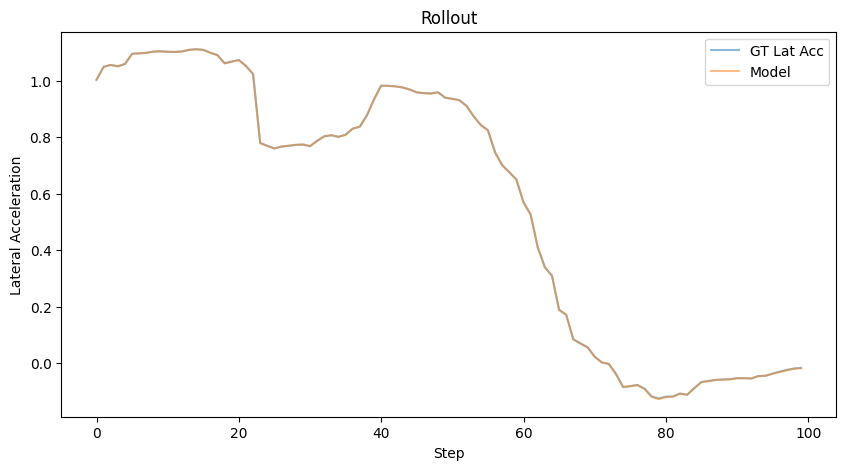

In [23]:
def plot_rollout(rollout, test_data):
  fig, ax = plt.subplots(figsize=(10, 5))
  ax.plot(test_data[:, 3], label="GT Lat Acc", alpha=0.5)
  ax.plot([latacc for latacc in rollout], label="Model", alpha=0.5)
  ax.legend()
  ax.set_xlabel("Step")
  ax.set_ylabel("Lateral Acceleration")
  ax.set_title("Rollout")
  plt.show()

plot_rollout(rollout, test_data)
